## 从创建的CSV文件中加载原始数据集

In [4]:
import pandas as pd
import os

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')
with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # 列名
    f.write('NA,Pave,127500\n')  # 每行表示一个数据样本
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

data = pd.read_csv(data_file) #pd.read_csv()就是pandas的阅读函数
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,106000
2,4.0,NaN,178100
3,NaN,NaN,140000


In [ ]:
#插值的方法
分割数据
inputs,outputs=data.iloc[:,0:2],data.iloc[:,2]
inputs = inputs.fillna(inputs.mean())
print(inputs)

### 代码行：inputs, outputs = [data.iloc[:, 0:2], data.iloc[:, 2]]
- data.iloc[:, 0:2]：
  - iloc：按位置索引（像 Excel 行号列号）。
  - :：所有行。
  - 0:2：列 0 和 1（第一列和第二列）。
  - 结果：前两列（NumRooms 和 Alley）作为 inputs（输入特征）。
- data.iloc[:, 2]：
  - 列 2（Price）作为 outputs（输出标签）。
- 整体：把数据分成输入（特征）和输出（目标）。

### 数据填充：mean() 与 fillna() 用法说明
## 1. inputs.mean() 计算均值
- **作用**：对 `inputs` 数据的前两列计算平均值
- **数值列（如 NumRooms）**：
  - 可以正常计算平均值（例如结果为 3.0）
  - 示例：`inputs['NumRooms'].mean()` → 3.0
- **字符串列（如 Alley）**：
  - 计算平均值无实际意义，会返回 NaN（空值）
  - 示例：`inputs['Alley'].mean()` → NaN

## 2. fillna(...) 填充空值
- **全称**：fill NA（填充空值）
- **核心逻辑**：使用计算得到的平均值，填充对应列中的空值
- **完整示例代码**：
```python
import pandas as pd

# 构造示例数据
data = {
    'NumRooms': [3, 2, None, 4, 3],  # 数值列，包含空值
    'Alley': ['Pave', None, 'Grvl', None, 'Pave']  # 字符串列，包含空值
}
inputs = pd.DataFrame(data)

# 计算前两列的均值（仅数值列有效）
mean_values = inputs.mean()
print("各列均值：")
print(mean_values)

# 用均值填充空值（仅数值列会被填充，字符串列仍为 NaN）
inputs_filled = inputs.fillna(mean_values)
print("\n填充空值后的数据：")
print(inputs_filled)

# get_dummies
# （注：这是 pandas 库中的一个函数，用于将分类变量转换为哑变量/指示变量，通常保留原名）
inputs = pd.get_dummies(inputs,dummy_na=True)
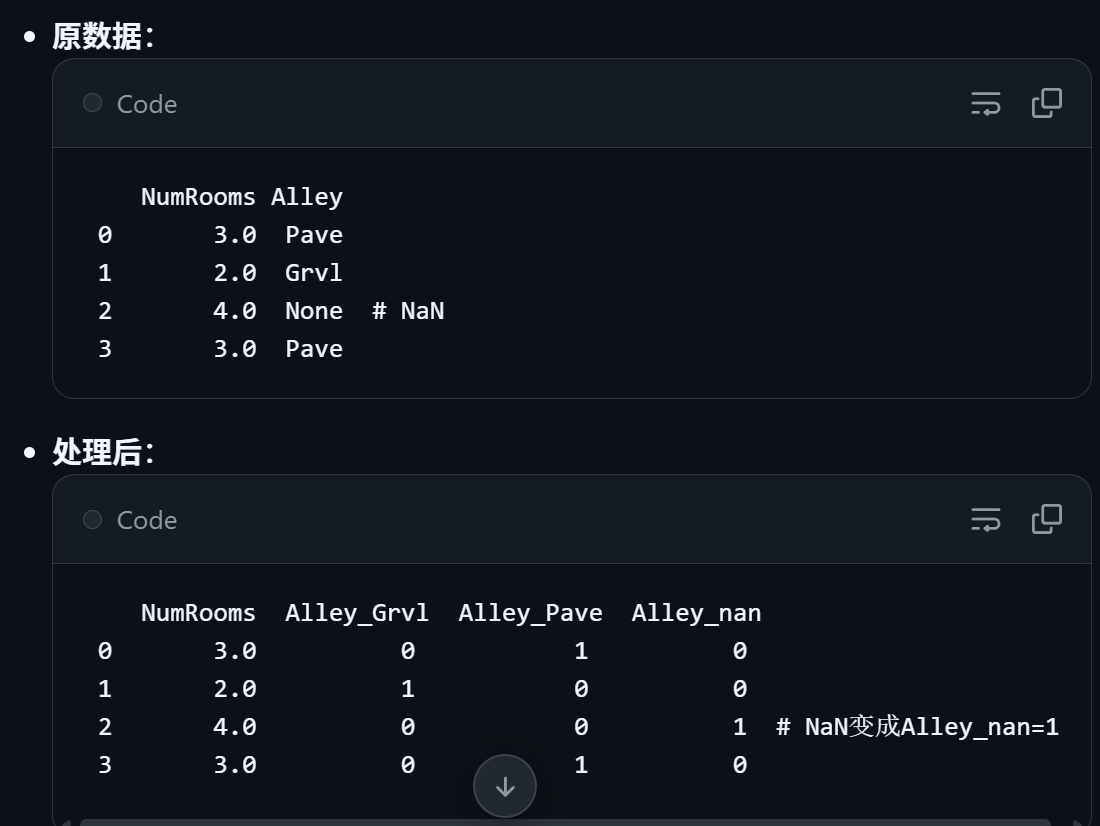

## 必须懂： “分类变量必须数字化才能进模型，且不能引入虚假的大小关系，所以要用 One-Hot。” —— 这个逻辑是 AI 没法替你决策的。
One-Hot 的意思就是：给每一个类别都单独开一个开关。

原本的一列 水果，变成了三列开关：

是苹果吗？ (1/0)

是香蕉吗？ (1/0)

是梨吗？ (1/0)

这样一来：

苹果就是 [1, 0, 0]

香蕉就是 [0, 1, 0]

梨就是 [0, 0, 1]

这解决了什么问题？
大家都是平等的！没有谁比谁大，也没有谁加谁等于谁。它们之间的距离都是一样的。

回到你李沐大神那张图：

Alley（小巷路面类型）里有 Pave（铺路）和 Grvl（碎石）。

如果你用 1 和 2 代表它们，模型会以为碎石路是铺路的两倍强（或者反过来）。

所以必须拆开： Alley_Pave 一列，Alley_Grvl 一列。

那个 NaN（空值）： 李沐觉得“没有路”也是一种特征，所以也给它开了一个开关 Alley_nan。

* import torch
* X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)
* X, y
# Pandas → PyTorch Tensor 转换：核心逻辑与细节拆解
## 1. 为什么要做这个转换？（核心逻辑）
- **Pandas (inputs, outputs)**：给**人**看的格式
  - 有表头（如 "NumRooms"）、行号（Index），像 Excel 表格，方便我们检查、清洗数据。
- **PyTorch Tensor (X, y)**：给**模型**“吃”的格式
  - 神经网络不认识“NumRooms”这类文字，只认识纯数字矩阵。
  - 类比：不能把写满字的《食谱》直接煮，要把食谱里的「原材料（数字）」拿出来才可以。

## 2. 代码细节拆解
### ① inputs.values 是什么？
- `inputs`：带表头、行号的 Pandas 表格（有“包装”）；
- `.values`：撕掉表头、行号，只保留裸露的纯数字（去掉包装纸，只剩“肉”）。

### ② torch.tensor(...) 是什么？
- PyTorch 的“专用包装袋”：把裸露的数字封装成 Tensor（张量）格式；
- 核心作用：只有 Tensor 格式，显卡（GPU）才能对数据进行高速计算。

## 3. 转换结果：X 和 y（对应可视化结果）
### X（大写）：特征矩阵（模型的“题目”）
- 对应 `get_dummies` 处理后的数字表格，是多行多列的矩阵；
- 示例：
```python
tensor([[3., 1., 0.],  # 第一间房：3个房间，Pave=1(铺路), Nan=0(非空)
        [2., 0., 1.],  # 第二间房：2个房间，Pave=0, Nan=1（假设仅保留这两列）
        ...])
